<a name="projet-7"></a>
# PROJET 7 : Loan Default Prediction #

<a name="contenu"></a>
## Contenu ##
- [Import des données](#import-des-donnees)
- [CSV en Parquet](#csv-en-parquet)
- [Exploration et data cleaning](#exploration-et-data-cleaning)
- [EDA Automation](#EDA-Automation)
- [Data Cleaning](#Data-Cleaning)
  - [Removing exclusions](#Removing-exclusions)
  - [Missing Value Imputation](#Missing-Value-Imputation)
  - [Removing Outlier](#Removing-Outlier)
- [Correlation Analysis](#Correlation-Analysis)
- [Feature Engineering](#Feature-Engineering)
  - [Binary Encoding for Binary Variables](#Binary-Encoding)
  - [Target Encoding for Multicategorical Variables](#Target-Encoding)
  - [Normalization for Numeric Variables](#Normalization)
- [Dealing with Imbalanced Dataset](#Dealing-with-Imbalanced-Dataset)
- [Feature Selection](#Feature-Selection)
- [Model Building](#Model-Building)
- [Model Evaluation on Hold-Out Set](#Model-Evaluation)




<a name="Objectifs"></a>
## Objectifs ##


_**Context :**_
- Financial institutions need to assess the risk of loan defaults.
- Accurate predictions can help in making informed lending decisions.
- Machine learning can analyze historical data to predict defaults.

_**Goal:**_
- Build a model to predict whether a loan will default based on applicant data.
- Identify the most significant factors contributing to defaults.
- Provide recommendations for risk mitigation.

_**Origine des données**_

- "All Lending Club loan data" (2007 through current Lending Club accepted and rejected loan data)
- URL : https://www.kaggle.com/datasets/wordsforthewise/lending-club/data


_**Challenges:**_
- Handling imbalanced datasets where defaults are less frequent.
- Feature engineering to capture relevant applicant characteristics.
- Interpreting the model to provide actionable insights.


In [ ]:
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as sps
import seaborn as sns

In [ ]:
# from datetime import datetime
# start_time = datetime.now()

# import tensorflow as tf
# from matplotlib import rcParams

# %matplotlib inline
# # figure size in inches
# rcParams['figure.figsize'] = 8,6


# # Plotly visualizations
# from plotly import tools
# # import chart_studio.plotly as py
# import plotly.figure_factory as ff
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# import plotly.offline as pyo
# import plotly.express as px
# init_notebook_mode(connected=True)

# # For oversampling Library (Dealing with Imbalanced Datasets)
# from imblearn.over_sampling import SMOTE
# from collections import Counter
# from sklearn.preprocessing import LabelEncoder

# from sklearn.pipeline import make_pipeline
# from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# from imblearn.under_sampling import NearMiss
# from imblearn.metrics import classification_report_imbalanced

# import math
# import itertools as it
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# import warnings
# warnings.filterwarnings("ignore")

# # Classifier
# from sklearn.svm import SVC

# # Other machine learning tools

# from sklearn.feature_selection import RFECV
# import scipy.stats as sps

# print('LOADING DURATION: ', datetime.now() - start_time)

# pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_columns', 20)

<a name="import-des-donnees"></a>
## [Import des données](#contenu) ##


In [ ]:
df = pd.read_csv("DATA/accepted_2007_to_2018Q4.csv")

In [ ]:
# Correction du format de 'id'

df['id'] = df['id'].astype(str)

In [ ]:
# Conversion de la colonne issue_d en format datetime

df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')

<a name="csv-en-parquet"></a>
## [CSV en Parquet](#contenu) ## 


In [ ]:
# Sauvegarder en parquet

df.to_parquet("DATA/accepted_2007_to_2018Q4.parquet")

print("Conversion terminée !")

In [ ]:
# Nettoyer la mémoire vive (RAM)

# 1. Supprimer le gros DataFrame chargé depuis le CSV
if 'df' in locals():
    del df

# 2. Forcer la libération de la mémoire
gc.collect()

# 3. Charger le nouveau fichier Parquet (beaucoup plus léger)
df = pd.read_parquet("DATA/accepted_2007_to_2018Q4.parquet")

print("Données chargées depuis le format Parquet !")
print(f"Dimensions du dataset : {df.shape}")

<a name="etude-loan-status-et-issue-d"></a>
## [Etude des colonnes "loan status" et "issue_d"](#contenu) ## 


In [ ]:
df['loan_status'].value_counts()

In [ ]:
# Filtre pour ne garder que les lignes "Current"
current_loans = df[df['loan_status'] == 'Current']

# Calcule des occurrences de issue_d sur ce sous-ensemble
counts = current_loans['issue_d'].value_counts().sort_index(ascending=False)

print("Aperçu des occurrences :")
print(counts)

In [ ]:
# Séparation en deux groupes en utilisant une simple comparaison de chaînes de caractères
mask_recent = counts.index >= '2017-01'
mask_old = counts.index <= '2016-12'

# Calcule de la somme pour chaque groupe
count_2017_2018 = counts[mask_recent].sum()
count_2016_and_before = counts[mask_old].sum()

print(f"Occurrences de 'Current' (2017-01 à 2018-12) : {count_2017_2018}")
print(f"Occurrences de 'Current' (2016-12 et inférieur) : {count_2016_and_before}")

In [ ]:
# Retrait des "current" trop récent pour tirer des conclusions 
lignes_a_supprimer = (df['loan_status'] == 'Current') & (df['issue_d'] >= '2017-01-01')

# On met à jour le dataframe
df = df[~lignes_a_supprimer].copy()

# Vérification
print(f"Nombre de lignes restantes dans le dataframe après nettoyage : {len(df)}")

In [ ]:
# Création d'un échantillon

# Sélection et concaténation des 100000 premières et 100000 dernières lignes
df_echantillon = pd.concat([df.head(100000), df.tail(100000)])

# Sauvegarde de cet échantillon dans un nouveau fichier CSV
# L'argument index=False évite de sauvegarder les anciens numéros de ligne comme une nouvelle colonne
df_echantillon.to_csv("DATA/accepted_2007_to_2018Q4_sample_200k.csv", index=False)

# Vérification des dimensions
print(f"L'échantillon a été créé avec succès !")
print(f"Dimensions du nouvel échantillon : {df_echantillon.shape}")

df = df_echantillon

<a name="exploration-et-data-cleaning"></a>
## [Exploration et data cleaning](#contenu) ##


In [ ]:
# Aperçu des 5 premières lignes

df.head()

In [ ]:
# Aperçu des 5 dernières lignes

df.tail()

<a name="Retrait des lignes de totalisation"></a>
### Retrait des lignes de totalisation ###


In [ ]:
# On cherche les lignes dont l'id contient "Total" (insensible à la casse)
lignes_total = df[df['id'].str.contains("Total", case=False, na=False)]

print(f"Nombre de lignes de totaux explicites détectées : {len(lignes_total)}")
print("\nContenu de la colonne 'id' pour ces lignes :")
print(lignes_total['id'].unique())

In [ ]:
# On ne garde que les lignes qui ne contiennent PAS "Total" dans l'id
df = df[~df['id'].str.contains("Total", case=False, na=False)]

print(f"Lignes de totaux purgées. Nouvelle taille : {len(df)}")

In [ ]:
# Compte des lignes où loan_amnt est manquant
nb_null_loan = df['loan_amnt'].isnull().sum()

print(f"Nombre de lignes parasites (loan_amnt nul) : {nb_null_loan}")

# Visualiser ces lignes pour confirmer qu'il s'agit bien de totaux
print("\nAperçu des colonnes 'id' de ces lignes :")
print(df[df['loan_amnt'].isnull()]['id'].unique())

In [ ]:
# Suppression des lignes où loan_amnt est NaN
df = df.dropna(subset=['loan_amnt'])

# Vérification de la nouvelle taille du dataset
print(f"Nettoyage terminé. Nouvelles dimensions : {df.shape}")

# Vérification visuelle de la fin du fichier
df.tail()

<a name="Vérification des lignes en doublon"></a>
### Vérification des lignes en doublon ###


In [ ]:
# Compter le nombre total de lignes 100% identiques
nb_doublons = df.duplicated().sum()

print(f"Nombre de lignes en doublon détectées : {nb_doublons}")

# Aperçu de ces doublons :
if nb_doublons > 0:
    print("\nAperçu des lignes dupliquées :")
    display(df[df.duplicated()].head())

<a name="Vérification des colonnes entièrement à Null"></a>
### Vérification des colonnes entièrement à Null ###


In [ ]:
# Liste des colonnes 100% nulles

all_null_cols = df.columns[df.isnull().all()].tolist()

if len(all_null_cols) > 0:
    print(f"Il y a {len(all_null_cols)} colonnes entièrement vides :")
    print(all_null_cols)
else:
    print("Aucune colonne n'est entièrement vide.")

In [ ]:
# Suppression de la colonne member_id

df = df.drop(columns=['member_id'])
print("La colonne 'member_id' a été supprimée.")

<a name="Suppression des colonnes Hardship, Settlement et historique"></a>
### Suppression des colonnes "Hardship", "Settlement" et historique du remboursement ###


In [ ]:
# Calcul du nombre de valeurs nulles par colonne
null_counts = df.isnull().sum()

# Affichage des 20 colonnes avec le plus de valeurs manquantes
print("Synthèse des valeurs manquantes (Top 20) :")
print(null_counts.sort_values(ascending=False).head(20))

**Suppression des colonnes "Hardship" (Plans de difficultés financières)**

Ces colonnes concernent les emprunteurs qui ont rencontré de graves problèmes financiers (perte d'emploi, maladie) et qui ont négocié un plan de sauvetage temporaire ("Hardship plan") avec Lending Club :

 *   hardship_reason : La cause de la difficulté (chômage, etc.).
 *   hardship_type : Le type de plan mis en place.
 *   hardship_status : Le statut du plan (actif, terminé, annulé).
 *   hardship_amount : Le montant de la mensualité pendant le plan.
 *   hardship_start_date / hardship_end_date : Dates de début et de fin du plan.
 *   hardship_length : La durée du plan en mois.
 *   hardship_dpd : Nombre de jours de retard de paiement (Days Past Due) au moment du plan.
 *   hardship_loan_status : Le statut du prêt pendant le plan.
 *   hardship_payoff_balance_amount : Le montant total restant à payer à l'issue du plan.
 *   hardship_last_payment_amount : Le dernier paiement effectué sous ce régime.
 *   payment_plan_start_date : Le jour où le plan a officiellement commencé.
 *   deferral_term : Le nombre de mois pendant lesquels le paiement a été repoussé.
 *   orig_projected_additional_accrued_interest : Les intérêts supplémentaires qui vont s'accumuler à cause de ce plan.

**Objectif de la suppression : éviter le Data Leakage** 

Ces informations n'existent que parce que l'emprunteur a déjà cessé de payer normalement. 
Or, le but du Machine Learning est de prédire le défaut au moment où le prêt est accordé, donc moment où toutes ces colonnes sont inexistantes.

In [ ]:
# Liste exhaustive des colonnes "Hardship"
cols_hardship = [
    'orig_projected_additional_accrued_interest',
    'hardship_reason', 
    'hardship_payoff_balance_amount',
    'hardship_last_payment_amount', 
    'payment_plan_start_date',
    'hardship_type', 
    'hardship_status', 
    'hardship_start_date',
    'deferral_term', 
    'hardship_amount', 
    'hardship_dpd',
    'hardship_loan_status', 
    'hardship_length', 
    'hardship_end_date',
    'hardship_flag'  
]

# Suppression des colonnes (errors='ignore' évite un plantage si une colonne est déjà absente)
df = df.drop(columns=cols_hardship, errors='ignore')

print("Les colonnes 'Hardship' ont été supprimées avec succès.")
print(f"Nouvelles dimensions du dataset : {df.shape}")

**Suppression des colonnes "Settlement" (Règlements de dettes)**

Ces colonnes s'activent lorsqu'un prêt a définitivement fait défaut ("Charged Off") et que le service de recouvrement négocie avec l'emprunteur pour récupérer au moins une partie de l'argent (par exemple, solder la dette pour 40% du montant restant) :

 *   settlement_status : Le statut de l'accord de règlement (ex: complet, rompu).
 *   settlement_date : La date à laquelle le recouvrement a accepté le règlement.
 *   settlement_amount : Le montant final convenu pour clore la dette.
 *   settlement_percentage : Le pourcentage de la dette initiale que représente le règlement.
 *   settlement_term : Le nombre de mois accordés pour payer ce règlement.
 *   debt_settlement_flag_date : La date à laquelle le dossier a été marqué comme "en cours de règlement".


**Objectif de la suppression : éviter le Data Leakage** 

Exactement comme pour le groupe "Hardship", un modèle qui voit un montant dans settlement_amount saura à 100% que le prêt est mauvais, rendant la prédiction inutile et biaisée.


In [ ]:
# Liste exhaustive des colonnes "Settlement"
cols_settlement = [
    'settlement_status',
    'debt_settlement_flag_date',
    'settlement_term',
    'settlement_percentage',
    'settlement_date',
    'settlement_amount',
    'debt_settlement_flag'  
]

# Suppression des colonnes (errors='ignore' évite un plantage si une colonne est déjà absente)
df = df.drop(columns=cols_settlement, errors='ignore')

print("Les colonnes 'Settlement' ont été supprimées avec succès.")
print(f"Nouvelles dimensions du dataset : {df.shape}")

**Suppression des colonnes liée à l'historique de remboursement du prêt et son état actuel**

 Ces variables décrivent l'historique de remboursement du prêt et son état actuel :

 *   out_prncp / out_prncp_inv : Capital restant dû (principal) sur le montant total financé / sur la part financée par les investisseurs.
 *   total_pymnt / total_pymnt_inv : Total des paiements reçus à ce jour pour le montant total financé / pour la part des investisseurs.
 *   total_rec_prncp : Capital (principal) remboursé par l'emprunteur à ce jour.
 *   total_rec_int : Intérêts remboursés par l'emprunteur à ce jour.
 *   total_rec_late_fee : Frais ou pénalités de retard perçus à ce jour.
 *   recoveries : Montants récupérés après que le prêt a été déclaré en perte (procédure de recouvrement post "charge-off").
 *   collection_recovery_fee : Frais de gestion facturés par les agences de recouvrement pour récupérer les fonds.
 *   last_pymnt_amnt : Montant du tout dernier paiement total reçu.
 *   last_pymnt_d : Date (mois) à laquelle le dernier paiement a été enregistré.
 *   last_credit_pull_d : Date la plus récente à laquelle le prêteur a consulté le dossier de crédit de l'emprunteur.
 *   next_pymnt_d : Date du prochain paiement.


**Objectif de la suppression : éviter le Data Leakage** 

Dans un projet de prédiction de défaut de paiement, l'objectif est de déterminer si un emprunteur va faire défaut au moment où il demande son prêt. Or, ces informations (paiements reçus, reliquat du capital, frais de retard) ne sont connues qu'après que le prêt a été accordé.

In [ ]:
# Liste des colonnes de "Data Leakage" (données futures ou liées au comportement de remboursement)
cols_leakage = [
    'out_prncp', 
    'out_prncp_inv', 
    'total_pymnt', 
    'total_pymnt_inv',
    'total_rec_prncp', 
    'total_rec_int', 
    'total_rec_late_fee',
    'recoveries', 
    'collection_recovery_fee', 
    'last_pymnt_amnt',
    'last_pymnt_d', 
    'last_credit_pull_d',
    'next_pymnt_d'
]

# Suppression des colonnes
df = df.drop(columns=cols_leakage, errors='ignore')

print("Les colonnes de 'Data Leakage' ont été supprimées avec succès.")
print(f"Nouvelles dimensions du dataset : {df.shape}")

**Suppression de la colonne "issue_d"**

Ce n'est techniquement pas du Data Leakage.
L'objectif est de prédire si un emprunteur va faire défaut avant de lui accorder le prêt.
Or, au moment où le client fait sa demande, la date du jour (qui deviendra le mois et l'année de issue_d) est connue.

Mais si l'on donne l'année "2014" ou "2015" à un algorithme, il risque d'apprendre des règles du type : "les prêts de 2014 ont eu beaucoup de défauts, donc l'année 2014 est un risque".

Le problème ? Quand vous déploierez ce modèle en production en 2025 ou 2026, l'algorithme ne saura pas comment interpréter ces nouvelles années qu'il n'a jamais vues pendant son entraînement. Il va donc perdre en performance.

Conserver issue_d dans les features risque d'apporter plus de problèmes (overfitting temporel) que de solutions. 


In [ ]:
# Suppression des colonnes
cols_leakage = ['issue_d']
df = df.drop(columns=cols_leakage, errors='ignore')

print("Les colonnes de 'Data Leakage' ont été supprimées avec succès.")
print(f"Nouvelles dimensions du dataset : {df.shape}")

<a name="Suppression des lignes des prêts conjoints"></a>
### Suppression des lignes des "prêts conjoints" ###


In [ ]:
# Calcul du nombre de valeurs nulles par colonne
null_counts = df.isnull().sum()

# Affichage des 20 colonnes avec le plus de valeurs manquantes
print("Synthèse des valeurs manquantes (Top 20) :")
print(null_counts.sort_values(ascending=False).head(20))

**Suppression des lignes avec un "Co-emprunteur" (sec_app_... et ..._joint)**

Des colonnes (comme annual_inc_joint ou sec_app_fico_range_low) correspondent aux informations d'un second demandeur lorsque le prêt est fait à deux (demande conjointe).

Or, les prêts conjoints (à deux emprunteurs) ont une dynamique de risque très différente des prêts individuels (les revenus et les dettes sont cumulés). Mélanger les deux dans un même modèle peut embrouiller l'algorithme. 

Dans la mesure où ces prêts conjoints ne représentent que quelques pourcents du dataset, il semble préférable de les retirer.

In [ ]:
# Voir combien il y a de prêts de chaque type
print("Répartition des types de prêts avant filtrage :")
print(df['application_type'].value_counts())

# Ne conserver que les prêts individuels
df = df[df['application_type'] == 'Individual']

# Supprimer la colonne 'application_type' devenue inutile
df = df.drop(columns=['application_type'])

print(f"\nPrêts conjoints supprimés ! Nouvelles dimensions : {df.shape}")

**Suppression des colonnes ne contenant aucune donnée**


In [ ]:
# Liste des colonnes 100% nulles

all_null_cols = df.columns[df.isnull().all()].tolist()

if len(all_null_cols) > 0:
    print(f"Il y a {len(all_null_cols)} colonnes entièrement vides :")
    print(all_null_cols)
else:
    print("Aucune colonne n'est entièrement vide.")

In [ ]:
# On supprime les colonnes qui sont 100% vides
df = df.dropna(axis=1, how='all')
print(f"Purge terminée ! Nouvelles dimensions du dataset : {df.shape}")

In [ ]:
# Calcul du nombre de valeurs nulles par colonne
null_counts = df.isnull().sum()

# Affichage des 20 colonnes avec le plus de valeurs manquantes
print("Synthèse des valeurs manquantes (Top 20) :")
print(null_counts.sort_values(ascending=False).head(20))

**Colonnes contenant du texte libre ou des données non structurées**

 *   emp_title (Titre du poste) : Le nom du poste ou métier renseigné librement par l'emprunteur lors de sa demande. Étant un champ de texte libre, il contient d'innombrables fautes de frappe, abréviations et variantes pour un même métier. En l'éat, il y a trop de valeurs uniques. Sans un traitement lourd, cette variable va faire "planter" ou sur-apprendre les modèles.

 *   desc (Description du prêt) : Un paragraphe rédigé par l'emprunteur pour expliquer pourquoi il a besoin de ce prêt. C'est du texte pur. Bien qu'il puisse contenir du sens, l'extraire demanderait des techniques de traitement qui sortent du cadre d'une modélisation standard.

 *   title (Titre du prêt) : Un titre court donné par l'emprunteur à son prêt (ex: "Debt Consolidation", "Credit Card Payoff"). Il fait doublon avec la colonne "purpose". Cependant, purpose est une liste déroulante contrôlée (donc propre et standardisée), alors que title est un texte libre soumis aux mêmes problèmes que emp_title.

 *   url (Lien URL) : L'adresse web de la page de la demande de prêt sur le site de Lending Club. Un lien web ne contient absolument aucune information statistique ou mathématique exploitable pour évaluer la solvabilité d'un individu.

 *   zip_code (Code postal) : Les trois premiers chiffres du code postal de l'emprunteur (pour des raisons d'anonymat, LC masque les derniers chiffres, ex: "902xx"). Même tronqués, les codes postaux génèrent beaucoup trop de catégories différentes. C'est trop lourd pour l'encodage. De plus, l'information géographique pertinente est déjà capturée de manière beaucoup plus propre par la colonne addr_state (l'État américain).



In [ ]:
# Liste des colonnes de texte libre et métadonnées non structurées
cols_unstructured = [
    'emp_title', 
    'desc', 
    'title', 
    'url', 
    'zip_code'
]

# Suppression des colonnes (errors='ignore' permet d'éviter un plantage si une colonne est déjà absente)
df = df.drop(columns=cols_unstructured, errors='ignore')

print("Les colonnes de texte libre et métadonnées ont été supprimées avec succès.")
print(f"Nouvelles dimensions du dataset : {df.shape}")

**Suppression de l'Id**

L'identifiant unique n'a aucun pouvoir de prédiction sur le comportement financier de l'emprunteur. Le conserver lors de l'entraînement obligerait le modèle de Machine Learning à chercher des corrélations mathématiques là où il n'y a que du bruit.

In [ ]:
# Suppression de la colonne 'id'
df = df.drop('id', axis=1)

# Alternative avec inplace=True pour modifier le DataFrame directement sans réassignation :
# df.drop('id', axis=1, inplace=True)

<a name="variable-cible"></a>
### Création de la variable cible (Loan Condition) ###


In [ ]:
# Création de la variable cible (Loan Condition)
bad_loan = [
    "Charged Off", 
    "Default", 
    "Does not meet the credit policy. Status:Charged Off", 
    "In Grace Period",
    "Late (16-30 days)", 
    "Late (31-120 days)"
]

df['loan_condition_int'] = df['loan_status'].apply(lambda status: 1 if status in bad_loan else 0).astype(int)
df['loan_condition'] = np.where(df['loan_condition_int'] == 0, 'Good Loan', 'Bad Loan')

# Vérification rapide
df.groupby(['loan_status', 'loan_condition', 'loan_condition_int']).size() \
    .reset_index(name='count') \
    .sort_values(by=['loan_condition', 'count'], ascending=[False, False])

<a name="transformation-variables"></a>
### Transformation de variables ###


In [ ]:
# Conversion de l'ancienneté professionnelle
emp_length_mapping = {
    '10+ years': 10,
    '9 years': 9,
    '8 years': 8,
    '7 years': 7,
    '6 years': 6,
    '5 years': 5,
    '4 years': 4,
    '3 years': 3,
    '2 years': 2,
    '1 year': 1,
    '< 1 year': 0.5,
    'n/a': 0
}

df['emp_length_int'] = df['emp_length'].map(emp_length_mapping)

# Vérification rapide
df.groupby(['emp_length', 'emp_length_int']).size() \
    .reset_index(name='count') \
    .sort_values(by=['emp_length_int', 'count'], ascending=[False, False])

In [ ]:
# Suppression de la colonne originale emp_length
df.drop(columns=['emp_length'], inplace=True)

# Vérification de la présence des colonnes restantes
print(f"La colonne 'emp_length' a été supprimée.")
print(f"Colonnes actuelles : {df.columns.tolist()}")

In [ ]:
# Cartographie des régions
state_to_region = {
    'CA': 'West', 'OR': 'West', 'UT': 'West', 'WA': 'West', 'CO': 'West',
    'NV': 'West', 'AK': 'West', 'MT': 'West', 'HI': 'West', 'WY': 'West', 'ID': 'West',
    'AZ': 'SouthWest', 'TX': 'SouthWest', 'NM': 'SouthWest', 'OK': 'SouthWest',
    'GA': 'SouthEast', 'NC': 'SouthEast', 'VA': 'SouthEast', 'FL': 'SouthEast', 'KY': 'SouthEast',
    'SC': 'SouthEast', 'LA': 'SouthEast', 'AL': 'SouthEast', 'WV': 'SouthEast', 'DC': 'SouthEast',
    'AR': 'SouthEast', 'DE': 'SouthEast', 'MS': 'SouthEast', 'TN': 'SouthEast',
    'IL': 'MidWest', 'MO': 'MidWest', 'MN': 'MidWest', 'OH': 'MidWest', 'WI': 'MidWest',
    'KS': 'MidWest', 'MI': 'MidWest', 'SD': 'MidWest', 'IA': 'MidWest', 'NE': 'MidWest',
    'IN': 'MidWest', 'ND': 'MidWest',
    'CT': 'NorthEast', 'NY': 'NorthEast', 'PA': 'NorthEast', 'NJ': 'NorthEast', 'RI': 'NorthEast',
    'MA': 'NorthEast', 'MD': 'NorthEast', 'VT': 'NorthEast', 'NH': 'NorthEast', 'ME': 'NorthEast'
}

df['region'] = df['addr_state'].map(state_to_region)

# Vérification rapide
df.groupby('region').size() \
    .reset_index(name='count') \
    .sort_values(by='count', ascending=False)

In [ ]:
# Suppression de la colonne addr_state devenue redondante
df.drop(columns=['addr_state'], inplace=True)

# Confirmation et affichage des colonnes restantes
print(f"La colonne 'addr_state' a été supprimée.")
print(f"Colonnes géographiques conservées : {[col for col in df.columns if 'region' in col]}")

In [ ]:
#reduce the data size to fasten following steps, otherwise the memory will soon run out
df_sample = df.sample(n=100000, random_state=42)

# EDA Automation
The following is an EDA(Exploratory Data Analysis) Automation.

The code allows for flexible variable selection, enabling more in-depth business insights to be gained.

**instruction:**
With designed functions, you can quickly plot by entering variables name (the corresponding variable can be selected in the corresponding comment behind the variable). If you run the code in Colab, you can directly select the variable through the drop-down. If not, 

In [ ]:
EDA_df = df_sample.copy()

EDA_cat_columns = EDA_df.select_dtypes(include=['object']).columns.tolist()
EDA_num_columns = EDA_df.select_dtypes(exclude=['object']).columns.tolist()

# Filter categorical columns with unique value count less than or equal to the specified threshold.
filtered_EDA_cat_columns = [col for col in EDA_cat_columns if EDA_df[col].nunique() <= 50]

In [ ]:
def plot_variable_distribution(dataframe, variable_name):
    if dataframe[variable_name].dtype == 'object':
        # Categorical variables, draw a histogram
        sns.countplot(x=variable_name, data=dataframe)
        plt.xlabel(variable_name)
        plt.ylabel('Count')
        plt.title(f'Distribution of {variable_name}')
    else:
        # Numeric variables, plot histograms
        sns.histplot(dataframe[variable_name], kde=True)
        plt.xlabel(variable_name)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {variable_name}')
    plt.show()

In [ ]:
variable = "loan_condition" # @param ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term', 'loan_condition_int', 'loan_condition', 'emp_length_int', 'region'] {allow-input: true}
plot_variable_distribution(EDA_df, variable)

In [ ]:
def plot_2_variable_relationship(dataframe, x_variable, y_variable):
    if dataframe[x_variable].dtype != 'object' and dataframe[y_variable].dtype != 'object':
        # Two numerical variables, draw a scatter plot
        sns.scatterplot(x=x_variable, y=y_variable, data=dataframe)
        plt.xlabel(x_variable)
        plt.ylabel(y_variable)
        plt.title(f'Scatter Plot: {x_variable} vs. {y_variable}')
    elif dataframe[x_variable].dtype == 'object' and dataframe[y_variable].dtype == 'object':
        # Two categorical variables, draw a crosstab
        cross_tab = pd.crosstab(index=dataframe[x_variable], columns=dataframe[y_variable], normalize='columns') #Show column summary percentage
        sns.heatmap(cross_tab, annot=True, cmap="YlGnBu")
        plt.xlabel(y_variable)
        plt.ylabel(x_variable)
        plt.title(f'Cross Tabulation: {x_variable} vs. {y_variable}')
    elif (dataframe[x_variable].dtype != 'object' and dataframe[y_variable].dtype == 'object') or (dataframe[x_variable].dtype == 'object' and dataframe[y_variable].dtype != 'object'):
        # One categorical variable, one numerical variabl"e, draw a violin plot
        if dataframe[x_variable].dtype != 'object':
            x_variable, y_variable = y_variable, x_variable  # Swap the order of the variables and make sure Y is a numeric variable
        sns.violinplot(x=x_variable, y=y_variable, data=dataframe)
        plt.xlabel(x_variable)
        plt.ylabel(y_variable)
        plt.title(f'Violin Plot: {x_variable} vs. {y_variable}')
        sns.despine()
    else:
        print("Unsupported combination of variable types")

In [ ]:
X = "loan_condition" 
Y = "loan_amnt"

plot_2_variable_relationship(EDA_df,X,Y) 

In [ ]:
def plot_3_variable_relationship(dataframe, x1_variable, x2_variable, y_variable):
    num_types = ['int64', 'float64']

    if (dataframe[x1_variable].dtype == 'object' and
        dataframe[x2_variable].dtype == 'object' and
        dataframe[y_variable].dtype == 'object'):
        # Three categorical variables, draw a crosstab
        cross_tab = pd.crosstab(index=dataframe[x1_variable], columns=[dataframe[x2_variable], dataframe[y_variable]], normalize='columns')
        sns.heatmap(cross_tab, annot=True, cmap="YlGnBu")
        plt.xlabel(f'{x2_variable} - {y_variable}')
        plt.ylabel(x1_variable)
        plt.title(f'Cross Tabulation: {x1_variable} vs. {x2_variable} vs. {y_variable}')
    elif (dataframe[x1_variable].dtype == 'object' and
          dataframe[x2_variable].dtype == 'object' and
          dataframe[y_variable].dtype in num_types):
        # X1 and X2 are categorical, Y is a numerical variable, draw a violin plot or boxplot
        # Example: Drawing a Violin Plot
        sns.violinplot(x=x1_variable, y=y_variable, hue=x2_variable, data=dataframe)
        plt.xlabel(x1_variable)
        plt.ylabel(y_variable)
        plt.title(f'Violin Plot: {x1_variable} vs. {x2_variable} vs. {y_variable}')
    elif (dataframe[x1_variable].dtype in num_types and
          dataframe[x2_variable].dtype in num_types and
          dataframe[y_variable].dtype == 'object'):
        # X1 and X2 are numerical variables, Y is a categorical variable, draw a box plot or violin plot
        # Example: Drawing a Violin Plot
        sns.boxplot(x=x1_variable, y=y_variable, hue=x2_variable, data=dataframe)
        plt.xlabel(x1_variable)
        plt.ylabel(y_variable)
        plt.title(f'Box Plot: {x1_variable} vs. {x2_variable} vs. {y_variable}')
    elif (dataframe[x1_variable].dtype in num_types and
          dataframe[x2_variable].dtype in num_types and
          dataframe[y_variable].dtype in num_types):
        # Three numerical variables, draw a scatter plot
        sns.scatterplot(x=x1_variable, y=x2_variable, hue=y_variable, data=dataframe)
        plt.xlabel(x1_variable)
        plt.ylabel(x2_variable)
        plt.title(f'Scatter Plot: {x1_variable} vs. {x2_variable} vs. {y_variable}')
    elif ((dataframe[x1_variable].dtype == 'object' and dataframe[x2_variable].dtype in num_types) or
          (dataframe[x1_variable].dtype in num_types and dataframe[x2_variable].dtype == 'object')):
        # One of X1 and X2 is a categorical variable and the other is a numerical variable
        if dataframe[y_variable].dtype == 'object':
            # Y is a categorical variable, draw a boxplot or violin plot
            sns.boxplot(x=x1_variable, y=x2_variable, hue=y_variable, data=dataframe)
            plt.xlabel(x1_variable)
            plt.ylabel(x2_variable)
            plt.title(f'Box Plot: {x1_variable} vs. {x2_variable} with Color-Coded {y_variable}')
        elif dataframe[y_variable].dtype in num_types:
            # Y is a numerical variable, draw a box plot or violin plot
            sns.boxplot(x=x1_variable, y=x2_variable, data=dataframe)
            plt.xlabel(x1_variable)
            plt.ylabel(x2_variable)
            plt.title(f'Box Plot: {x1_variable} vs. {x2_variable}')
    else:
        print("Unsupported combination of variable types")


In [ ]:
X1 = "grade"
X2 = "term" 
Y = "loan_amnt"

plot_3_variable_relationship(EDA_df,X1,X2,Y)

<a name="Data-Cleaning"></a>
# Data Cleaning

This part includes:


*   Removing Exclusions
*   Missing Value Imputation
*   Removing Outliers

<a name="Removing-exclusions"></a>
## Removing Exclusions


**Delete variables with more than 80% missing values**

There are a lot of columns which have huge chunk of data missing. These columns are not necessary for our analysis. The following part will drop any columns where 20% or more data is missing, which means only columns whose number of non-null values is at least 80% of the total number of rows in the dataset will be retained.

In [ ]:
drop_df = df_sample


In [ ]:
def get_missing_value_stats(input_df):
    df_null = pd.DataFrame({
        'Missing Count': input_df.isnull().sum(),
        'Missing Percent': 100 * input_df.isnull().sum() / len(input_df),
        'Type': input_df.dtypes
    })
    missing_values = df_null[df_null['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False) #改
    return missing_values

def get_value_stats(input_df):
    df_null = pd.DataFrame({
        '#Count': input_df.notna().sum(),
        '%Populated': 100 * input_df.notna().sum() / len(input_df),
        '#Unique Values':input_df.nunique(),
        'Most Common Value': input_df.mode().iloc[0],
        'Type': input_df.dtypes
    })

    missing_values = df_null[df_null['#Count'] > 0].sort_values(by='#Count', ascending=False)

    return missing_values

# Finding the the count and percentage of values that are missing.
get_missing_value_stats(drop_df)

In [ ]:
#drop any columns where over a certain percentage is missing
drop_df = drop_df.dropna(axis=1, thresh=int(0.20*len(drop_df)))
get_missing_value_stats(drop_df)

<a name="Missing-Value-Imputation"></a>
## Missing Value Imputation


<table>
  <tr><th>index</th><th>Count</th><th>Percent</th><th>Type</th><th>Imputation method</th></tr>
  <tr><td>tot_coll_amt</td><td>66689</td><td>24.06</td><td>float64</td><td>0</td></tr>
  <tr><td>total_rev_hi_lim</td><td>66689</td><td>24.06</td><td>float64</td><td>0</td></tr>
  <tr><td>tot_cur_bal</td><td>66689</td><td>24.06</td><td>float64</td><td>0</td></tr>
  <tr><td>emp_length_int</td><td>11101</td><td>4.005</td><td>float64</td><td>median</td></tr>
  <tr><td>last_pymnt_d</td><td>921</td><td>0.332</td><td>object</td><td>mode</td></tr>
  <tr><td>revol_util</td><td>253</td><td>0.091</td><td>float64</td><td></td></tr>
  <tr><td>collections_12_mths_ex_med</td><td>145</td><td>0.052</td><td>float64</td><td></td></tr>
  <tr><td>pub_rec</td><td>29</td><td>0.0104</td><td>float64</td><td>median</td></tr>
  <tr><td>delinq_2yrs</td><td>29</td><td>0.0104</td><td>float64</td><td>mean</td></tr>
  <tr><td>last_credit_pull_d</td><td>24</td><td>0.0086</td><td>object</td><td>mode</td></tr>
  <tr><td>annual_income</td><td>4</td><td>0.00144</td><td>float64</td><td>mean</td></tr>
  <tr><td>income_category</td><td>4</td><td>0.00144</td><td>object</td><td>mode</td></tr>
</table>

In [ ]:
fillna_df = drop_df.copy()

# # for object variables - Get the mode of next payment date and last payment date and the last date credit amount was pulled
# for column in ["last_pymnt_d", "last_credit_pull_d"]:  #, 'income_category'
#     fillna_df[column] = fillna_df.groupby("region")[column].transform(lambda x: x.fillna(x.mode()))

# for numerical variables
# Get the mode on the number of accounts in which the client is delinquent
fillna_df["pub_rec"] = fillna_df.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))
# Get the mode of the total number of credit lines the borrower has
fillna_df["total_acc"] = fillna_df.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))

fillna_df["emp_length_int"] = fillna_df.groupby("region")["emp_length_int"].transform(lambda x: x.fillna(x.median()))

# Get the mean of the annual income depending on the region the client is located.
fillna_df["annual_inc"] = fillna_df.groupby("region")["annual_inc"].transform(lambda x: x.fillna(x.mean()))
# Mode of credit delinquencies in the past two years.
fillna_df["delinq_2yrs"] = fillna_df.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# # for other, fill in with zero
# fillna_df.fillna(0, inplace=True)
# fillna_df.isnull().sum().max() # Maximum number of nulls.

In [ ]:
# Identifier et remplir les colonnes numériques avec le chiffre 0
cols_num = fillna_df.select_dtypes(include=['number']).columns
fillna_df[cols_num] = fillna_df[cols_num].fillna(0)

# Identifier et remplir les colonnes de texte avec le texte "0" (ou "Inconnu", "Missing", etc.)
cols_str = fillna_df.select_dtypes(include=['object', 'str']).columns
fillna_df[cols_str] = fillna_df[cols_str].fillna("0")

# Vérifier le nombre maximum de valeurs nulles restantes
fillna_df.isnull().sum().max()

In [ ]:
len(fillna_df['loan_condition_int'])
# Loan Ratios (Imbalanced classes)
fillna_df['loan_condition_int'].value_counts()/len(fillna_df['loan_condition_int']) * 100

<a name="Removing-Outliers"></a>
## Removing Outliers

Custom thresholds were used to remove outliers
(3-sigma method did not work well)

In [ ]:
#Custom thresholds
RemoveOutlier_df = fillna_df.copy()
print("Dataset before removing outlier:",RemoveOutlier_df.shape)
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['annual_inc'] <= 250000]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['dti'] <= 50]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['open_acc'] <= 40]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['total_acc'] <= 80]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['revol_util'] <= 120]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['revol_bal'] <= 250000]
RemoveOutlier_df.reset_index(drop=True, inplace=True)
print("Dataset after removing outlier:",RemoveOutlier_df.shape)

RemoveOutlier_df.head().transpose()

<a name="Correlation-Analysis"></a>
# Correlation Analysis

Correlation analysis was performed on the variables to assess their importance and relationship to the target variable y. This provided insights into the most relevant variables for predicting good vs bad loans.

For the correlation analysis, categorical variables were label encoded to enable numeric correlation values to be calculated. While this encoding can introduce artificial numerical relationships, it provided a convenient quick view of variable importance.

For the actual model building later on, more appropriate encodings like target encoding were used for the categorical variables.

In [ ]:
target_col = target_variable = "loan_condition_int"

In [ ]:
corr_df = RemoveOutlier_df.copy() 

# correlation with y
correlation_with_loan_condition = corr_df.select_dtypes(include=['int64', 'float64']).corr()[target_variable]
sorted_correlation = correlation_with_loan_condition.drop(target_variable).sort_values(ascending=False)

# plot
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_correlation.index, y=sorted_correlation.values, orient='v')
plt.xlabel('Correlation with{}'.format(target_variable))
plt.title('Features Correlation with{}'.format(target_variable))
plt.xticks(rotation=90)
plt.show()
print(sorted_correlation)

In [ ]:
# Select the variables with the highest correlation with the dependent variable and explore the correlation between them
top_variables = sorted_correlation.abs().nlargest(10).index.tolist()

plt.figure(figsize=(20, 20))
correlation_matrix = RemoveOutlier_df[top_variables].corr()
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='bwr', vmin=-1, vmax=1, square=True, linewidths=0.5, mask=mask)
plt.title('Correlation Heatmap for Numeric Columns of Interest')
plt.show()

In [ ]:
# # Further, explore the specific distribution of the relationship between variables under the action of the dependent variable loan_condition_int
# # This runs a bit slowly, so run with caution
sample_corr_df = corr_df[top_variables + [target_variable]].sample(n=1000, random_state=42)
sns.pairplot(sample_corr_df,hue=target_variable, diag_kind='kde',corner=True)

<a name="Feature-Engineering"></a>
# Feature Engineering

Steps:
- **Binary Encoding** for binary (Boolean) variables
- **Target Encoding** for multivariate variables
- **Normalization** for numeric variables


Note:
In order to prevent data leakage, target encoding and normalization should only be completed on the training set, and then use the same rules to change the test set.


Something to mention:

- Train Test Split: use StrattifiedShuffleSplit to have approximately the same ratio of bad loans compared to good loans in both training and testing data. --important to imbalanced dataset
- Target Encoding: use smooth method to avoid overfitting


In [ ]:
TE_df = RemoveOutlier_df.copy()

In [ ]:
# divide variables into numerical variables and categorical variables, categorical variables are divided into binary variables and multivariate variables
original_cols = TE_df.columns

cat_cols = TE_df.select_dtypes(include=['object']).columns.tolist()
num_cols = [col for col in TE_df.select_dtypes(exclude=['object']).columns.tolist() if col not in ['id', 'loan_condition_int']]

dual_cat_cols = [col for col in cat_cols if TE_df[col].nunique()<=2]
multi_cat_cols =[col for col in cat_cols if TE_df[col].nunique()>2]

multi_cat_cols

<a name="Binary-Encoding"></a>
## Binary Encoding for Binary Variables

In [ ]:
# pair all categorical features with another categorical feature
import itertools
def combine_categories(dataframe, cat_cols, expand_dim=False):
    df = dataframe.copy()
    combined = list(itertools.combinations(cat_cols, 2))
    for c1, c2 in combined:
        df.loc[:, f'{c1}__{c2}'] = df[c1].astype(str) + '_' + df[c2].astype(str)
        if expand_dim:
            cat_cols.append(f'{c1}__{c2}')
    return df, cat_cols

# binary encoding for dual_cat_cols
TE_df = pd.get_dummies(TE_df, columns=dual_cat_cols, drop_first=True)

# update dual_cat_cols
changed_columns = [col for col in TE_df.columns if col not in original_cols]
dual_cat_cols = changed_columns

TE_df.head().transpose()

## Train Test Split

The purpose of the code below is to have the same ratio across our training and test sets.

This should better be done before target encoding and normalization to avoid data leakage.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #Specify test_size to account for 20%

for train_set, test_set in stratified.split(TE_df, TE_df[target_col]):
    stratified_train = TE_df.loc[train_set]
    stratified_test = TE_df.loc[test_set]

train_df = stratified_train
test_df = stratified_test

# Let's Shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

print(train_df[target_col].value_counts()/len(TE_df))
print(test_df[target_col].value_counts()/len(TE_df))
train_df.shape

In [ ]:
# separates the y(target variables) and X(features) for the training and testing datasets

train_y = train_df[[target_col]]
test_y = test_df[[target_col]]

train_X = train_df.drop(target_col, axis=1, inplace=False)
test_X = test_df.drop(target_col, axis=1, inplace=False)

train_X.shape

until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | `train_X` | `train_y` |
| test | `test_X` | `test_y` |

<a name="Target-Encoding"></a>
## Target Encoding for Multicategorical Variables

In [ ]:
from category_encoders import TargetEncoder

# Create a data set containing only multi-categorical variables
multi_cat_train_X = train_X[multi_cat_cols]
multi_cat_test_X = test_X[multi_cat_cols]

# Target encode categorical variables with smoothing method (on train set)
encoder = TargetEncoder(smoothing=0.2)
encoder.fit(multi_cat_train_X, train_y)

# Apply the same encoding rules on train and test set
encoded_multi_cat_train_X = encoder.transform(multi_cat_train_X)
encoded_multi_cat_test_X = encoder.transform(multi_cat_test_X)

encoded_train_X = pd.concat([train_X.drop(columns=multi_cat_cols), encoded_multi_cat_train_X], axis=1)
encoded_test_X = pd.concat([test_X.drop(columns=multi_cat_cols), encoded_multi_cat_test_X], axis=1)

encoded_train_X.head().transpose()

until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | `encoded_train_X` | `train_y` |
| test | `encoded_test_X` | `test_y` |

<a name="Normalization"></a>
## Normalization for Numeric Variables

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and apply normalization on the training set
standardized_train_X = encoded_train_X.copy()
standardized_train_X[num_cols] = scaler.fit_transform(encoded_train_X[num_cols])

# Apply the same normalization rules on the test set
standardized_test_X = encoded_test_X.copy()
standardized_test_X[num_cols] = scaler.transform(encoded_test_X[num_cols])

standardized_train_X.head().transpose()

until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | `standardized_train_X` | `train_y` |
| test | `standardized_test_X` | `test_y` |

<a name="Dealing-with-Imbalanced-Dataset"></a>
# Dealing with Imbalanced Dataset
Our data set is an unbalanced data set (80% good loans). What we are more concerned about is the accuracy of bad loan prediction, so balancing the data is particularly important.



Balanced data can be oversampled or undersampled. Random undersampling and SMOTE (oversampling) methods are provided below. Since the data set is very large, the data set after undersampling is used subsequently. In comparison, the authenticity of the data is guaranteed.

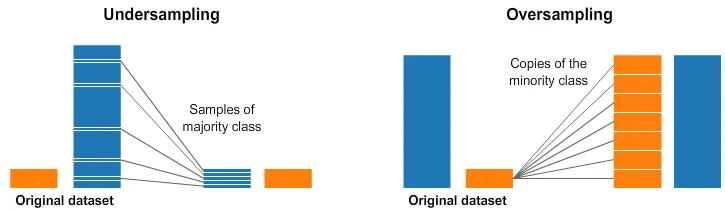

Undersamping our data

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)

# Undersampling the training set
standardized_train_X_undersample, train_y_undersample = undersampler.fit_resample(standardized_train_X, train_y) 


print('standardized_train_X_undersample.shape',standardized_train_X_undersample.shape)
train_y_undersample['loan_condition_int'].value_counts().to_frame()

until now (undersampling), we have：


| train vs test | X | y |
| --- | --- | --- |
| train | standardized_train_X_undersample | train_y_undersample |
| test | standardized_test_X | test_y |

Or you can use SMOTE. After testing, the effect is similar to the model after Undersampling.

In [ ]:
# smote = SMOTE(random_state=42)

# # oversampling the training set
# train_X_SMOTE, train_y_SMOTE = smote.fit_resample(standardized_train_X, train_y)

<a name="Feature-Selection"></a>
# Feature Selection


*   Filter
*   Wrapper



In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=1)
selector.fit(standardized_train_X_undersample)

filtered_feature_names = standardized_train_X_undersample.columns[selector.get_support()]
standardized_train_X_undersample_filtered = standardized_train_X_undersample[filtered_feature_names]

standardized_train_X_undersample_filtered.shape

In [ ]:
#modify this if you want to use SMOTE
to_wrap_train_X = standardized_train_X_undersample_filtered.copy()
train_y = train_y_undersample.copy()

In [ ]:
nfeatures = len(to_wrap_train_X.columns)
nfeatures

Stepwise selection wrapper will take a lot of time, so you can skip it directly and use the results I got after running it, as follows:

In [ ]:
vars_final = ['delinq_2yrs',
 'last_fico_range_high',
 'last_fico_range_low',
 'acc_now_delinq',
 'open_acc_6m',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'all_util']

Or if you have time you can run it yourself （Ctrl+/ Uncomment and run）

In [ ]:
# %%time
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

# nfeatures = len(to_wrap_train_X.columns)
# clf = RandomForestClassifier(n_estimators=5, n_jobs=-1)
# sfs = SFS(clf, k_features=nfeatures, forward=True, verbose=2, cv=2, n_jobs=-1)
# sfs.fit(to_wrap_train_X, train_y)

# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
# vars_FS

In [ ]:
# vars_final = list(vars_FS.loc[15, 'feature_names'])
# vars_final

In [ ]:
# fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(8, 5))
# plt.xticks(np.arange(0, len(to_wrap_train_X.columns), step=5))

# # plt.ylim([0.9, 1.0])
# plt.xlim(0,len(to_wrap_train_X.columns))
# plt.title('Stepwise Selection')
# plt.grid()
# plt.show()

In [ ]:
# Use wrapper to reduce variables
wrapped_train_X = to_wrap_train_X.filter(vars_final, axis=1)
wrapped_test_X = standardized_test_X.filter(vars_final, axis=1)


print("final train/test X shape (target encoded):", wrapped_train_X.shape, wrapped_test_X.shape)
print("final train/test y shape:", train_y.shape, test_y.shape)

In [ ]:
wrapped_train_X.head()

until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | wrapped_train_X | train_y |
| test | wrapped_test_X | test_y |

<a name="Model-Building"></a>
# Model Building

Models:


*   Logistic Regression
*   Decision Tree
*   K Nearest Neighbors
*   Random Forest
*   Gaussian Naive Bayes
*   Light GBM
*   XGBoost
*   Gradient Boosting
*   Neural Network

**5-fold Cross Validation**: The model was trained on the training set and 5-fold cross-validation was used to assess model accuracy during training.



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

def plot_confusion_matrix(mean_conf_matrix, xtick_labels=None, ytick_labels=None):
    fig, axes = plt.subplots(figsize=(8, 6))
    default_style = sns.axes_style()
    # sns.set(font_scale=1.5)
    ax = sns.heatmap(mean_conf_matrix.T, annot=True, cmap='Blues', fmt=".1f",annot_kws={"size": 18})
    if xtick_labels:
        ax.set_xticklabels(xtick_labels)
    if ytick_labels:
        ax.set_yticklabels(ytick_labels)


    ax.set_xlabel('True Label')
    ax.set_ylabel('Predicted Label')
    ax.axis('equal')
    plt.title('Mean Confusion Matrix')
    sns.set_style(default_style)
    plt.show()

def calculate_scores(model, X_trn, y_trn, X_tst, y_tst):
    """Calculate various classification scores on the test set"""
    model.fit(X_trn, y_trn)
    y_pred = model.predict(X_tst)
    accuracy = accuracy_score(y_tst, y_pred)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_tst, y_pred)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_tst, y_pred)
    recall = recall_score(y_tst, y_pred)
    f1 = f1_score(y_tst, y_pred)

    y_pred_proba = model.predict_proba(X_tst)[:,1]
    auc = roc_auc_score(y_tst, y_pred_proba)

    mask = y_tst['loan_condition_int'].astype(bool).values
    churn = y_pred_proba[mask]
    not_churn = y_pred_proba[~mask]
    ks = sps.ks_2samp(churn, not_churn)[0]

    return accuracy, auc, ks, conf_matrix, precision, recall, f1

def fit_first_level(models, X_trn, y_trn, X_tst):
    """
    Prepare first-level model fitting for stacking. Only used during model stacking.
    Output the predicted probabilities of the first-level models as features for the stacking model.
    """
    # Create dataframes to store predictions of the first-level models
    X2_trn = np.zeros((len(X_trn), 2 * len(models)))
    X2_tst = np.zeros((len(X_tst), 2 * len(models)))

    for i, model in enumerate(models.values()):
        print("Stacking with", model)

        model.fit(X_trn, y_trn)
        y_trn_pred_proba = model.predict_proba(X_trn)
        y_tst_pred_proba = model.predict_proba(X_tst)

        X2_trn[:, i*2:(i+1)*2] = y_trn_pred_proba
        X2_tst[:, i*2:(i+1)*2] = y_tst_pred_proba

    return X2_trn, X2_tst

def calculate_cv_scores(model, X, y, cv=5, stacking=False, models=None, verbose=False):
    """Calculate average k-fold cross-validated classification scores"""
    kf = KFold(n_splits=cv, shuffle=True)
    accuracy_scores = []
    auc_scores = []
    ks_scores = []
    conf_matrices = []  # Store confusion matrices for each fold
    precision_scores = []
    recall_scores = []
    f1_scores = []
    fold_count = 0

    for train_index, test_index in kf.split(X):
        X_trn, X_tst = X.iloc[train_index], X.iloc[test_index]
        y_trn, y_tst = y.iloc[train_index], y.iloc[test_index]

        if stacking:
            # smote = False
            X_trn, X_tst = fit_first_level(models, X_trn, y_trn, X_tst)

        accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(model, X_trn, y_trn, X_tst, y_tst)
        accuracy_scores.append(accuracy)
        auc_scores.append(auc)
        ks_scores.append(ks)
        conf_matrices.append(conf_matrix)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # if verbose:
        #     print(f"Fold {fold_count} accuracy, auc, ks:", accuracy, auc, ks)

        fold_count += 1

    # mean confusion matrix
    mean_conf_matrix = np.mean(conf_matrices, axis=0) #/ np.sum(np.mean(conf_matrices, axis=0)))
    print(f"Mean Confusion Matrix for Model:\n", mean_conf_matrix)
    plot_confusion_matrix(mean_conf_matrix, xtick_labels=['Good Loan', 'Bad Loan'], ytick_labels=['Good Loan', 'Bad Loan'])

    return np.mean(accuracy_scores), np.mean(auc_scores), np.mean(ks_scores), np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores)

def fit_models_summary(models, X, y, cv=5, smote = False,undersample = False):
    """
    Calculate average k-fold cross-validated classification scores for multiple models.
    Generate a summary dataframe.
    """
    baseline = pd.DataFrame(columns=['accuracy', 'auc', 'ks', 'precision', 'recall', 'f1'])

    for name, model in models.items():
        # accuracy, auc, ks, precision, recall, f1 = calculate_cv_scores(model, X, y, cv=cv, smote=False)
        # baseline.loc[name] = [accuracy, auc, ks, None, precision, recall, f1]

        accuracy, auc, ks, precision, recall, f1 = calculate_cv_scores(model, X, y, cv=cv)

        if smote:
            baseline.loc["{} (SMOTE)".format(name)] = [accuracy, auc, ks, precision, recall, f1]
        if undersample:
            baseline.loc["{} (undersample)".format(name)] = [accuracy, auc, ks, precision, recall, f1]

        print(f"{name} processed")

    return baseline

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

mss=60
msl=int(mss/2)

models = {
     'Logistic Regression': LogisticRegression(),
     'Decision Tree': DecisionTreeClassifier(max_depth=10,min_samples_split=mss,min_samples_leaf=msl),
     'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=20),
     'Random Forest': RandomForestClassifier(n_estimators=20,max_depth=10),
     'Gaussian Naive Bayes': GaussianNB(var_smoothing=1),
     'Light GBM': LGBMClassifier(n_estimators=50,max_depth=3),
     'XGBoost': XGBClassifier(n_estimators=50,max_depth=3),
     'Gradient Boosting': GradientBoostingClassifier(n_estimators=50,max_depth=3),
     "Neural Network": MLPClassifier(hidden_layer_sizes = (10,10)),
# #     'Support Vector Machine': SVC()
}

In [ ]:
# test baseline models on undersampling dataset
baseline_tgt = fit_models_summary(models, wrapped_train_X, train_y, undersample=True)

In [ ]:
baseline_tgt

<a name="Model-Stacking"></a>
# Model Bagging and Stacking

Bagging

In [ ]:
models = {
     'Logistic Regression': LogisticRegression(),
     'Decision Tree': DecisionTreeClassifier(max_depth=10,min_samples_split=mss,min_samples_leaf=msl),
    #  'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=20),
     'Random Forest': RandomForestClassifier(n_estimators=20,max_depth=10),
    #  'Gaussian Naive Bayes': GaussianNB(var_smoothing=1),
     'Light GBM': LGBMClassifier(n_estimators=50,max_depth=3),
     'XGBoost': XGBClassifier(n_estimators=50,max_depth=3),
     'Gradient Boosting': GradientBoostingClassifier(n_estimators=50,max_depth=3),
     "Neural Network": MLPClassifier(hidden_layer_sizes = (10,10))
}

In [ ]:
print("Colonnes Train:", wrapped_train_X.shape[1])
print("Colonnes Test:", wrapped_test_X.shape[1])

In [ ]:
colonnes_en_trop_dans_test = set(wrapped_test_X.columns) - set(wrapped_train_X.columns)
colonnes_manquantes_dans_test = set(wrapped_train_X.columns) - set(wrapped_test_X.columns)

print("En trop dans test:", colonnes_en_trop_dans_test)
print("Manquantes dans test:", colonnes_manquantes_dans_test)

In [ ]:
# Identification des colonnes communes pour éviter les erreurs de "Feature names mismatch"
common_columns = [col for col in vars_final if col in standardized_train_X_undersample.columns and col in standardized_test_X.columns]

# Ré-alignement stricte des deux sets sur ces colonnes (même nombre, même ordre)
wrapped_train_X = standardized_train_X_undersample[common_columns]
wrapped_test_X = standardized_test_X[common_columns]

print(f"Nombre de colonnes utilisées : {len(common_columns)}")
# Vérification de l'alignement parfait
assert all(wrapped_train_X.columns == wrapped_test_X.columns), "Les colonnes ne sont toujours pas alignées !"

In [ ]:
from sklearn.ensemble import BaggingClassifier

performance_df = pd.DataFrame(columns=['accuracy', 'auc', 'ks', 'precision', 'recall', 'f1'])

bagging_models = {}

for model_name, model in models.items():
    print("processing: ", model_name)
    bagging_model = BaggingClassifier(estimator=model, n_estimators=10, random_state=42)

    # Training Bagging model
    bagging_model.fit(wrapped_train_X, train_y)

    bagging_models[model_name + '_bagging'] = bagging_model
    accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(bagging_model, wrapped_train_X, train_y, wrapped_test_X, test_y)
    performance_dict = {
        'accuracy': accuracy,
        'auc': auc,
        'ks': ks,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    performance_df.loc[model_name + ' (bagging)'] = performance_dict
    
performance_df

Stacking

In [ ]:
%%time
stack_model = XGBClassifier(max_depth = 3)
accuracy, auc, ks, precision, recall, f1 = calculate_cv_scores(stack_model, wrapped_train_X, train_y,
                                        stacking = True, models = models,
                                        verbose = True)
print('Stacking baseline:')
print('Accuracy:', accuracy)
print('AUC:', auc)
print('recall:', recall)

<a name="Model-Evaluation"></a>
# Model Evaluation on Test Set
**Performance on test set:** models were evaluated on the held-out test set to obtain true test accuracy.

In [ ]:
holdout_summary = pd.DataFrame(columns = ['accuracy','auc','ks','precision','recall','f1'])

X_trn, y_trn = wrapped_train_X, train_y

for name, model in models.items():
    accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(model, X_trn, y_trn, wrapped_test_X, test_y)
    holdout_summary.loc[name] = [accuracy, auc, ks, precision, recall, f1]

X2_trn, X2_tst = fit_first_level(models, wrapped_train_X, train_y, wrapped_test_X)


# add bagging model performance
for model_name, bagging_model in bagging_models.items():
    accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(bagging_model, wrapped_train_X, train_y, wrapped_test_X, test_y)
    holdout_summary.loc[model_name] = [accuracy, auc, ks, precision, recall, f1]


# add stack model performance
stack_model = XGBClassifier()
accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(stack_model, X2_trn, train_y, X2_tst, test_y)
holdout_summary.loc['Stacking Model (XGB)'] = [accuracy, auc, ks, precision, recall, f1]

In [ ]:
holdout_summary

**Conclusion**
- The performance scores on the hold-out set are nearly the same with the cross-validated scores on the training set. This is a good sign that the models don't overfit.
- The performance of the models are very close to each other. For computation and interpretability concerns, the Logistic Regression/ Decision Tree/ Random Forest model with undersampling method is recommended.